# Machine Learning Engineer Nanodegree -Quora question pairs
## Capstone Project



## I. Definition

### Project Overview

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both groups in the long term. Ideally, these duplicate questions would be merged together into a single canonical question, as doing so would provide several benefits: 
• It saves the question asker time if their question has already been answered previously on the site. 
 • Frequently repeated questions can frustrate highly engaged users whose feeds become polluted with redundant questions. 
• Q&A knowledge bases have more value to users and researchers when there is a single canonical question and collections of answers, 
• Having knowledge of alternative phrasings of the same question can improve search and discovery. 

A prevalent problem in online Q&A forums like Stack Overflow, Stack Exchange and Quora, for which combining the answers for duplicate questions asked by their users improves the efficiency and the quality of their service.
Relevant work: https://web.stanford.edu/class/cs224n/reports/2748045.pdf
I will perform numerous experiments using publicly available Quora’s Question Pairs dataset https://www.kaggle.com/c/quora-question-pairs/data,  which consists of 400000 pairs of questions labeled as duplicates or not duplicates.

### Problem Statement

The problem to be solved is to determine if two different questions asked by Quora users, are they have the same meaning? There might be lot difference in the way users ask a question, so it’s quite challenging to understand the intend of the questions, and put them in the same bucket. This is more of a type classification problem, where you basically answer with yes or no.  The input for the problem is two questions, some of the new input features can be added after preprocessing of the data like shared wight, len_diff. output is either 1 if they are same question or 0 if not.

### Metrics

The evaluation metric that will be used for measuring the performance of the models will be the log los between the true and the predicted values. Log Loss quantifies the accuracy of a classifier by penalizing false classifications. Minimizing the Log Loss is basically equivalent to maximizing the accuracy of the classifier, but there is a subtle twist which we’ll get to in a moment.
The mathematical formula for determining the log loss is the following: 
-log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp)) 
where y is the real value and p the predicted one. 

## II. Analysis

### Data Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

First I will read the training data and display few lines to get an overview of the data and information available./

In [2]:
data_train = pd.read_csv('data/train.csv')
data_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In this dataset we can find the following information:
* qid1: Unique ID of question 1
* qid2: Unique ID of question 2
* question1: Content of question 1
* question2: Content of question 2
* is_duplicate: A label stating if both questions are the same (1) or not (0)

Next, I will display some basic statistics about the dataset.

In [3]:
print("Number of rows: %d" %len(data_train))
dup = data_train[data_train.is_duplicate == 1]
n_dup = data_train[data_train.is_duplicate == 0]
print("Number of Duplicate pair of questions: %d" %len(dup))
print("Number of Non duplicate pair of questions: %d" %len(data_train[data_train.is_duplicate == 0]))

qids = data_train.qid1.tolist() + data_train.qid2.tolist()
print("Number of Unique questions: %d" %len(set(qids)))

Number of rows: 404290
Number of Duplicate pair of questions: 149263
Number of Non duplicate pair of questions: 255027
Number of Unique questions: 537933


### Exploratory Visualization

Next, a brief analysis of the questions in the training set. I will use nltk library for this, and I will display an histogram to see the frequency of the lengths of the questions.

[nltk_data] Downloading package punkt to /Users/rchoudhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


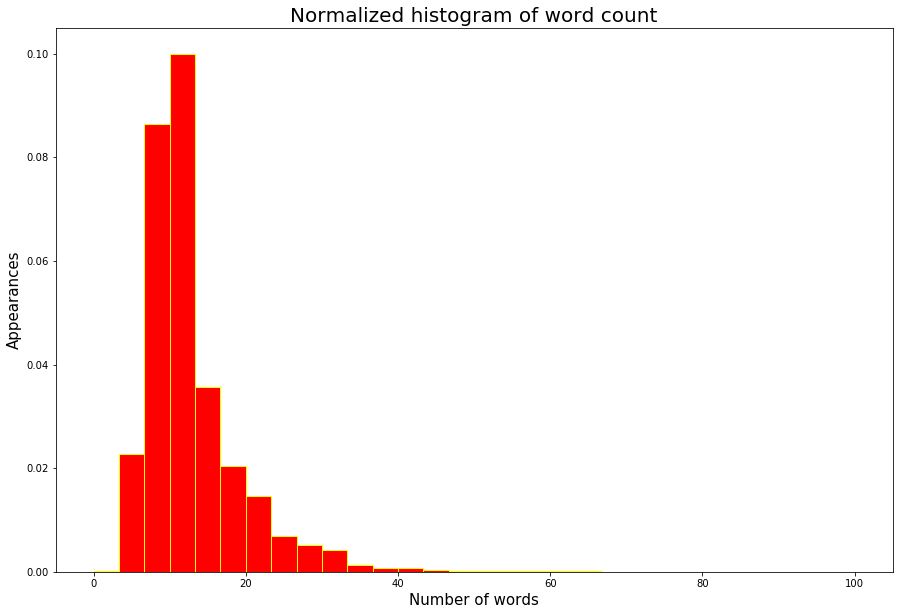

In [4]:
import nltk
nltk.download('punkt')
q_tok = []
q_tok += [nltk.tokenize.word_tokenize(i) for i in data_train.question1.apply(lambda x: str(x).decode('utf-8'))]
q_tok += [nltk.tokenize.word_tokenize(i) for i in data_train.question2.apply(lambda x: str(x).decode('utf-8'))]

word_count = [len(i) for i in q_tok]

plt.figure(figsize=(15,10))
plt.hist(word_count, bins=30,facecolor='red', edgecolor='yellow',range=[0,100], normed=True)
plt.title("Normalized histogram of word count", fontsize=20)
plt.xlabel("Number of words", fontsize=15)
plt.ylabel("Appearances", fontsize=15)
plt.show()

From the above figure its clear that most of the questions are composed from about 8 to 12 words. There are some of them which can have even more than 30 words. I will not exclude these outliers for now, because when comparing lengths I will use the absolute value, and not a normalized one. Hence, outliers should not affect my outcome. 

### Algorithms and Techniques

For this project I will evaluate 3 algorithms: AdaBoost, Random Forest and XGBoost. The reason for this is that they are all ensemble methods, which work well for problems where the features are weak learners. In this problem all the features will be so, because there doesn't seem to be one that is highly correlated with the meaning of the question.

I will try the 3 models and determine which has the minimum log-loss. After that, I will tune this model to find the best possible parameters for this problem.

### Benchmark: Naive predictor
For rhe Benchmark for testing the effectiveness of this model, I will use a predictor that evaluates if two questions are equal just based on the probability of this happening. I will assign this same probability to every pair of questions. I will upload this result to the Kaggle platform an evaluate the log-loss obtained. This will be my benchmark to see if I can obtain a better model for this.

In [5]:
prob = data_train.is_duplicate.mean()

In [6]:
data_test = pd.read_csv("data/test.csv")

In [7]:
results = pd.DataFrame(data_test.test_id)

In [8]:
test_is_duplicate = []

for i in range(len(results.test_id)):
    test_is_duplicate.append(prob)

In [9]:
results['is_duplicate'] = test_is_duplicate
results.head()
results.to_csv('sub/naive_predictor.csv', index=False)

The log-loss obtained was **0.55411**. This will be used as a benchmark, and any model with a lower value will be considered better.

In [10]:
del results

## III. Methodology

### Data Preprocessing

I will be exexuting the following steps for data cleaning and preprocessing.

* Remove stop words: In these steps i will remove stop words these words actually does not provide any information to find the similarity between two questions, eg: you, that, yours, are, etc
* Apply stemming: steming algorithm find the root of a word, like box, boxex are will be cosider similar after applying the algorithm, it will beacame box.
* Tokenize: This will split the questions in mutiple words.
* Tf-Idf: term frequency will help to find the importance of each word and inverse documnent frequency find the relative importance of a word in document, which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.
* DiffLib: This is a Python library that will help me finding differences between 2 strings. Specifically, I will be using the SequenceMatcher method.

By doing above mentioned steps, I will get a new set of features, which will be composed of:
* shared_weights: a measure of how many words both questions share, weighted by the tf-idf value of each word.
* shared_count_scaled: it will represent the normalized amount of words that they have in common.
* len_dif: the difference between the lengths of the questions.
* z_match_ratio: the value obtained from the SequenceMatcher method.


### Implementation

Defination of the function that will be used for preprocessing.

###### Remove stop words and appl stemming.

In [11]:
from nltk.stem.snowball import SnowballStemmer
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stemmer method and stop words
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # Adds punctuation to stopwords


def cleanQuestions(q_list):
    clean_questions = []

    for i in range(len(q_list)):
        q1 = ''
        for j in re.findall(r"[\w']+", str(q_list[i])):
            if j not in stop_words:
                q1 += stemmer.stem(j)
                q1 += " "
        q = ''
        for j in q1.split(): # Because the first words where not taken before
            if j not in stop_words:
                q += j
                q += " "
        clean_questions.append(q.strip()) # To remove the last blank space
        
    return clean_questions

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rchoudhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###### Tf-Idf

Applying tf-idf as discussed earlier.
First i will find the unique questions, otherwise it might give different results.

In [12]:
def uniqueQuestions(questions1_clean, questions2_clean):
    questions = []

    for i in tqdm(range(len(questions1_clean))):
        questions.append(str(questions1_clean[i]))
        questions.append(str(questions2_clean[i]))
    
    questions = set(questions)

    print("There are %d unique questions in the dataset." %len(questions))
    
    return questions

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfIdfVectorizer(questions):
    
    # Obtain the Tf-Idf value of each word using sklearn lib.
    vectorizer = TfidfVectorizer(max_df=0.5)
    tfidf = vectorizer.fit_transform(questions)
    idf = vectorizer.idf_
    # Create and return a dictionary with every word as a key, and its respective weight as a value
    return dict(zip(vectorizer.get_feature_names(), idf))

###### Tokenize

In [14]:
def tokenizeQuestions(q):
    return [nltk.tokenize.word_tokenize(i) for i in q]

###### Getting the weighted percentage of shared words

First, I need a list of the shared words, and a list of all the words for each pair

In [15]:
def findSharedWords(quest1, quest2):
    shared_words = []
    total_words = []

    for i in tqdm(range(len(quest1))):
        shared = []
        total = []
        for w in quest1[i]:
            total.append(w)
            if w in quest2[i]:
                shared.append(w)
        for w in quest2[i]:
            total.append(w)
            if w in quest1[i]:
                shared.append(w)
        shared_words.append(shared)
        total_words.append(total)
    return shared_words, total_words

Next, wil create 2 new lists with the shared and total weights, using the idf dictionary created before.

In [16]:
def findSharedWeights(shared_words, total_words):
    shared_weights = []
    total_weights = []
    not_in_dict = []
    for i in tqdm(range(len(shared_words))):
        shared = []
        total = []
        for w in shared_words[i]:
            try:
                shared.append(idf_dict[w])
            except:
                not_in_dict.append(w)
                shared.append(0)
        for w in total_words[i]:
            try:
                total.append(idf_dict[w])
            except:
                not_in_dict.append(w)
                shared.append(0)
        shared_weights.append(shared)
        total_weights.append(total)
    return shared_weights, total_weights

Finally, store shared weight/ total weight in a list.

In [17]:
def getWeights(shared_weights, total_weights):
    weights = []
    for i in range(len(shared_weights)):
        shared = 0
        total = 0
        for j in range(len(shared_weights[i])):
            shared += shared_weights[i][j]
        for j in range(len(total_weights[i])):
            total += total_weights[i][j]
        if total == 0:
            weights.append(0)
        else:
            weights.append(shared / total)
    return weights

I will now apply these transformations to the training dataset.

In [18]:
questions1 = data_train.question1.tolist()
questions2 = data_train.question2.tolist()

questions1_clean = cleanQuestions(questions1)
questions2_clean = cleanQuestions(questions2)

questions = uniqueQuestions(questions1_clean, questions2_clean)

100%|██████████| 404290/404290 [00:00<00:00, 670871.59it/s]

There are 509543 unique questions in the dataset.


In [19]:
idf_dict = tfIdfVectorizer(questions)

In [20]:
unique_tokens = [nltk.tokenize.word_tokenize(str(i)) for i in questions]

In [21]:
question1_token = tokenizeQuestions(questions1_clean)
print 'Questions 1 tokenized.'
question2_token = tokenizeQuestions(questions2_clean)
print 'Questions 2 tokenized.'

shared_words, total_words = findSharedWords(question1_token, question2_token)

Questions 1 tokenized.


  3%|▎         | 10812/404290 [00:00<00:03, 107602.40it/s]

Questions 2 tokenized.


100%|██████████| 404290/404290 [00:04<00:00, 85361.70it/s] 


In [22]:
shared_weights, total_weights = findSharedWeights(shared_words, total_words)

100%|██████████| 404290/404290 [00:04<00:00, 96581.76it/s] 


In [23]:
weights = getWeights(shared_weights, total_weights)

I will start a new DataFrame and fill it with the features I create.

In [24]:
X = pd.DataFrame(weights, columns=['shared_weights'])
X.head()

,shared_weights
0,0.950408
1,0.652899
2,0.517698
3,0.000000
4,0.237645


In order to be able to test the algorithms, I will now generate a new DataFrame with the label for each pair of questions. This label will have value 0 if they don't mean the same, and 1 if they do.

In [25]:
y = pd.DataFrame(data_train.is_duplicate, columns=['is_duplicate'])
y.head()

,is_duplicate
0,0
1,0
2,0
3,0
4,0


For each new feature that I create, I will plot the distribution of the duplicate and non duplicate questions, in order to see if this feature seems to be useful for predicting. I will start defining a function that will allow me to do this easier.

In [26]:
def plotDistribution(feature, desc):
    plt.figure(figsize=(15, 5))
    plt.hist(X[y['is_duplicate'] == 0][feature].tolist(), bins=20, normed=True,facecolor='green',edgecolor='yellow', label='Not Duplicate')
    plt.hist(X[y['is_duplicate'] == 1][feature].tolist(), bins=20, normed=True,facecolor='red',edgecolor='yellow', alpha=0.7, label='Duplicate')
    plt.legend()
    plt.title('Label distribution over ' + desc, fontsize=15)
    plt.xlabel(desc, fontsize=15)
    plt.ylabel('frequency', fontsize=15)
    plt.show()

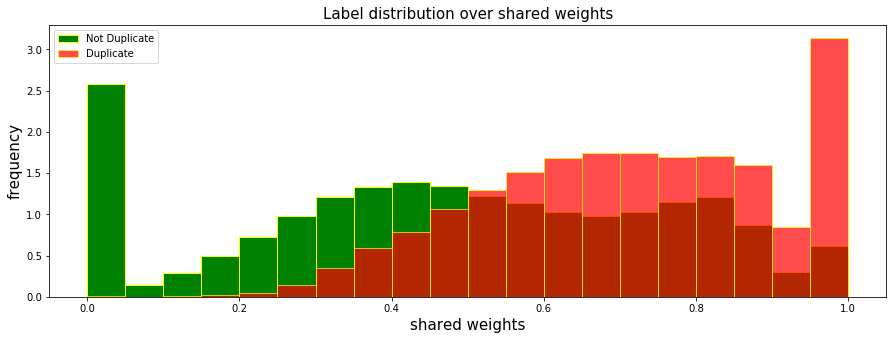

In [27]:
plotDistribution('shared_weights', 'shared weights')

This feature, **shared_weights**, looks to give some information about the equalness of a pair of questions.

The next feature I will generate will be the number of shared words in both questions.

In [28]:
shared_count = [len(x) for x in shared_words]

In order to see the distribution of this feature, I will plot an histogram. I will define a function that will allow me to do this easier for future features.

In [29]:
def plotHistogram(feature, desc):
    plt.figure(figsize=(15, 5))
    plt.hist(feature,facecolor='red',edgecolor='yellow', bins=40)
    plt.title('Distribution of ' + desc, fontsize=15)
    plt.xlabel(desc, fontsize=15)
    plt.ylabel('frequency', fontsize=15)
    plt.show()

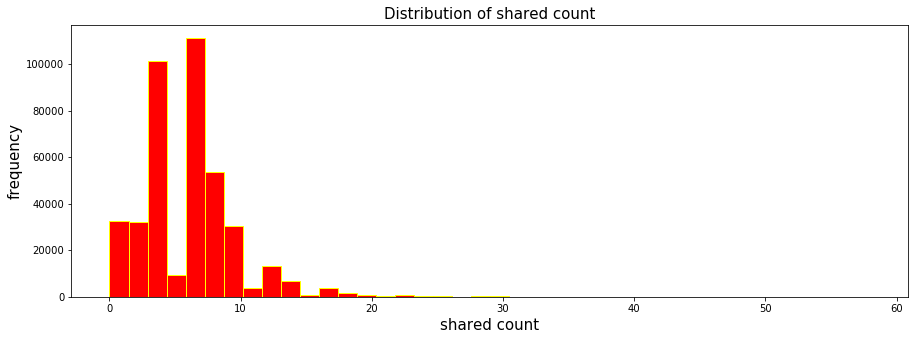

In [30]:
plotHistogram(shared_count, 'shared count')

I will use the MinMaxScaler function of sklearn, for scaling this feature before using it. As we can see in the prior histogram, most of the cases share 10 words or less, so just to make it relvant i will consider ouliers beyond 10 as just 10.

In [31]:
from sklearn.preprocessing import MinMaxScaler

shared_count_cut = [x if x < 10 else 10 for x in shared_count]

shared_count_scaled = MinMaxScaler().fit_transform(np.array(shared_count_cut, dtype='float64').reshape(-1, 1))

X['shared_count_scaled'] = shared_count_scaled.reshape(-1, 1)

del shared_count, shared_count_cut, shared_count_scaled

X.head()

,shared_weights,shared_count_scaled
0,0.950408,1.0
1,0.652899,0.8
2,0.517698,0.6
3,0.000000,0.0
4,0.237645,0.4


To see how useful this feature is, I will use the function created before and analyze the plot.

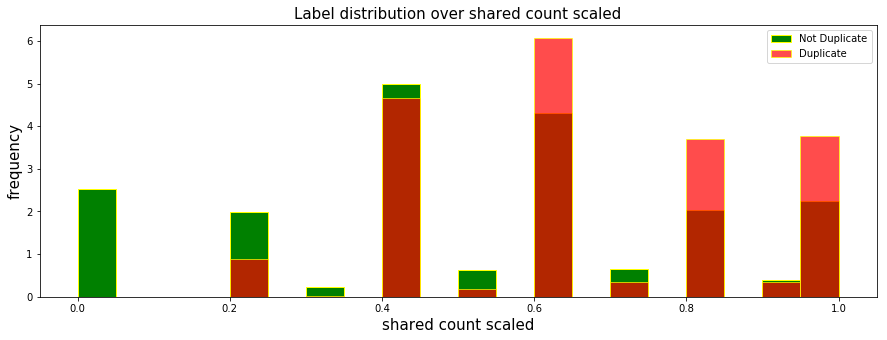

In [32]:
plotDistribution('shared_count_scaled', 'shared count scaled')

I can see that pairs with a higher value tend to be duplicated in more cases than the ones with lower values.

The next feature I will add is the difference in the length of the question. Again, I will scale it to get a value between 0 and 1.

In [33]:
question1_len = [len(x) for x in question1_token]
question2_len = [len(x) for x in question2_token]

len_dif = []

for i in range(len(question1_len)):
    len_dif.append(abs(question1_len[i] - question2_len[i]))

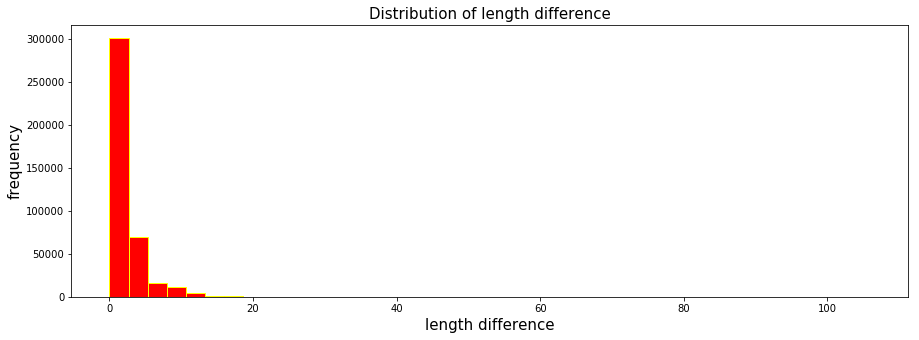

In [34]:
plotHistogram(len_dif, 'length difference')

I can see from this plot that most of the values are lower than 5, so again I will convert higher values to 5, and then rescale it with the MinMaxScaler method.

In [35]:
len_dif_cut = [5 if i > 5 else i for i in len_dif]
len_dif_cut = np.array(len_dif_cut).reshape(-1, 1)

len_dif_scaled = MinMaxScaler().fit_transform(len_dif_cut)

X['len_dif'] = len_dif_scaled

del len_dif, len_dif_cut

X.head()

,shared_weights,shared_count_scaled,len_dif
0,0.950408,1.0,0.2
1,0.652899,0.8,1.0
2,0.517698,0.6,0.2
3,0.000000,0.0,1.0
4,0.237645,0.4,1.0


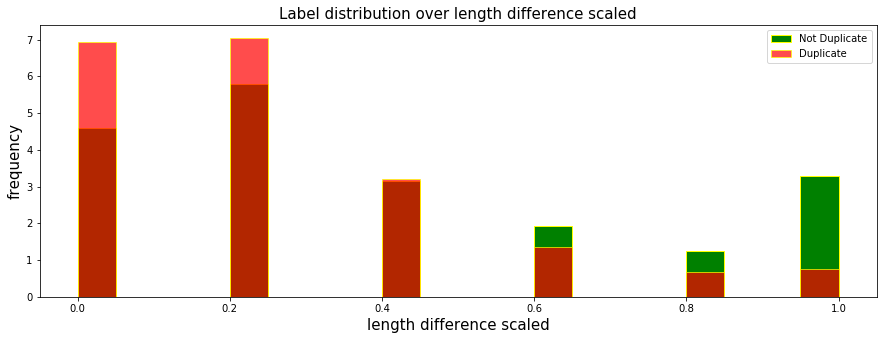

In [36]:
plotDistribution('len_dif', 'length difference scaled')

Again, this feature seems to be useful for predicting.

### DiffLib

In [37]:
import difflib

def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

In [38]:
z_match_ratio = []

for i in tqdm(range(len(data_train))):
    z_match_ratio.append(diff_ratios(data_train.question1[i], data_train.question2[i]))
                         
X['z_match_ratio'] = z_match_ratio

X.head()

100%|██████████| 404290/404290 [02:39<00:00, 2527.81it/s]


,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.950408,1.0,0.2,0.926829
1,0.652899,0.8,1.0,0.661871
2,0.517698,0.6,0.2,0.439394
3,0.000000,0.0,1.0,0.086957
4,0.237645,0.4,1.0,0.365217


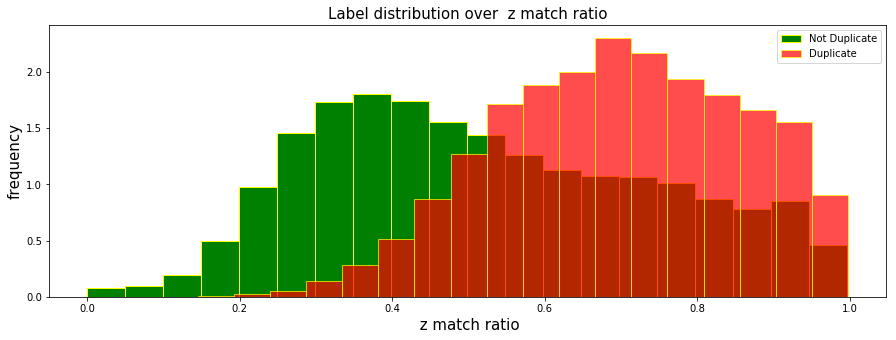

In [39]:
plotDistribution('z_match_ratio', ' z match ratio')

Finally, I will split the features and labels into a training and test set, in order to look for a good model. At the end, when I finally decide which to use, I will use the whole set for training, and I will test using the Kaggle testing set.

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

###### Model selection

Now that I have both the features that I will try, and the labels for each data point, I will start with the analysis of 3 different models which might obtain a good result: Random forest, AdaBoost and XGBoost.

In [41]:
from sklearn.metrics import log_loss

###### AdaBoost

In [42]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=50)
clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.680521


###### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf= RandomForestClassifier(n_estimators=100)

clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.643501


###### XGBoost

In [44]:
import os

import xgboost as xgb

In [45]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.03
params['max_depth'] = 5

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.684466	test-logloss:0.684601
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.619656	test-logloss:0.620855
[20]	train-logloss:0.580234	test-logloss:0.582094
[30]	train-logloss:0.554887	test-logloss:0.557155
[40]	train-logloss:0.537898	test-logloss:0.540523
[50]	train-logloss:0.526442	test-logloss:0.529314
[60]	train-logloss:0.518565	test-logloss:0.521638
[70]	train-logloss:0.513149	test-logloss:0.516361
[80]	train-logloss:0.509454	test-logloss:0.512774
[90]	train-logloss:0.506628	test-logloss:0.510028
[99]	train-logloss:0.504747	test-logloss:0.50822


As we can see, the three models have a similar log-loss, so in order to determine which is potentially better, I should tune each of them to find the best possible parameters. In the next section, I will focus on that.

### Refinement

In order to find which is the best of the three models, I will tune them and see which one gives me the lowest log-loss. For tuning, I will use the GridSearchCV tool from the scikit-learn library.

In [46]:
from sklearn.model_selection import GridSearchCV

I will now define a function that will allow me to use GridSearchCV in a simpler way.

In [47]:
def gridSearch(clf, base=None, params={}, base_params={}):
    start = time.time()
    
    param_grid = dict()
    for i in params.keys():
        param_grid[i] = params[i]
    for i in base_params.keys():
        param_grid['base_estimator__' + i] = base_params[i]
    if base == None:
        pass
    else:
        clf = type(clf)(base_estimator=base, random_state=50)
    gs = GridSearchCV(clf, param_grid, scoring='neg_log_loss')
    gs.fit(x_train, np.ravel(y_train))
    
    end = time.time()
    
    pred = gs.predict_proba(x_test)
    print 'Time taken: %f seconds' %(end - start)
    print 'Log loss: %f' %log_loss(y_test, pred)
    best_params = [i + ': ' + str(gs.best_params_[i]) for i in gs.best_params_.keys()]
    print 'Best parameters:'
    if params != {}:
        print '   Classifier:'
        for i in range(len(params.keys())):
            print '      ' + best_params[i]
    if base_params != {}:
        print '   Base Estimator:'
        for i in range(len(base_params.keys())):
            print '      ' + best_params[i + len(params.keys())][16:]

For every model I will apply GridSearchCV to a series of parameters that I consider they have a bigger effect on log-loss. I tried every single parameter before, and given the results I chose these. In order to make it quicker, I will try them separately. If I put all of them together the search can take a very long time.

###### AdaBoost

In [48]:
from sklearn.tree import DecisionTreeClassifier
gridSearch(AdaBoostClassifier(random_state=50), 
           base=DecisionTreeClassifier(), 
           base_params={'min_samples_split':[10, 30], 
                        'min_samples_leaf':[10, 30]})

Time taken: 3844.312000 seconds
Log loss: 0.541379
Best parameters:
   Base Estimator:
      min_samples_split: 10
      min_samples_leaf: 30


In [49]:
gridSearch(AdaBoostClassifier(random_state=50),
          base=DecisionTreeClassifier(min_samples_split=10,
                                     min_samples_leaf=30),
           params={'n_estimators':[70, 50]},
           base_params={'min_weight_fraction_leaf': [0.0, 0.01]}
          )

Time taken: 3190.134000 seconds
Log loss: 0.543411
Best parameters:
   Classifier:
      n_estimators: 70
   Base Estimator:
      min_weight_fraction_leaf: 0.0


In [50]:
gridSearch(AdaBoostClassifier(n_estimators=70, random_state=50),
          base=DecisionTreeClassifier(min_samples_split=10,
                                     min_samples_leaf=30,
                                     min_weight_fraction_leaf=0.0),
           params={'learning_rate':[0.1, 0.3, 0.5]})

Time taken: 4177.514000 seconds
Log loss: 0.544321
Best parameters:
   Classifier:
      learning_rate: 0.5


The best log-loss obtained from AdaBoost algorithm is **0.54**.

###### Random Forest

In [51]:
gridSearch(RandomForestClassifier(random_state=50), 
          params={'n_estimators':[100, 200]})

Time taken: 1109.031000 seconds
Log loss: 0.623910
Best parameters:
   Classifier:
       n_estimators: 200


In [52]:
gridSearch(RandomForestClassifier(n_estimators=200, 
                                  random_state=50), 
          params={'min_samples_leaf': [5, 10]})

Time taken: 603.131000 seconds
Log loss: 0.504013
Best parameters:
   Classifier:
      min_samples_leaf: 10


The best log-loss obtained from RandomForest is **0.50**.

###### XGBoost

In order to use GridSearchCV with XGBoost, I will need to use the sklearn implementation of this algorithm.

In [53]:
xgbclf = xgb.XGBClassifier(seed=50)

gridSearch(xgbclf, 
          params={'max_depth': [2, 3, 4],
                 'reg_alpha': [0.3, 0.5]})

Time taken: 124.388130 seconds
Log loss: 0.501172
Best parameters:
   Classifier:
      reg_alpha: 0.5
      max_depth: 4


In [54]:
xgbclf = xgb.XGBClassifier(max_depth=4, 
                           reg_alpha=0.5,
                           seed=50)

gridSearch(xgbclf, 
          params={'learning_rate': [0.1, 0.3, 0.5],
                 'gamma': [0.0, 0.1]})

Time taken: 163.283536 seconds
Log loss: 0.496270
Best parameters:
   Classifier:
      learning_rate: 0.3
      gamma: 0.0


In [55]:
xgbclf = xgb.XGBClassifier(max_depth=4, 
                           reg_alpha=0.5,
                           learning_rate=0.3,
                          gamma=0.0,
                           seed=50)

gridSearch(xgbclf, 
          params={'reg_lambda': [0.5, 0.7, 1],
                'min_child_weight': [0.5, 1, 2]})

Time taken: 241.865434 seconds
Log loss: 0.496455
Best parameters:
   Classifier:
      reg_lambda: 1
      min_child_weight: 0.5


The log loss obtained from XGBoost is **0.49**.

I will choose the **XGBoost** algorithm, given that it has the lowest log loss, and it is by far the fastest to train.

###### Rebalancing positive an negative cases

Based on this article from Kaggle and it's comments, I know that the distribution of possitive and negative cases in the test data is not the same as the one in the training data: https://www.kaggle.com/davidthaler/quora-question-pairs/how-many-1-s-are-in-the-public-lb/run/1013730. In the training data we have around 37% of positive cases, while the test data has around 16.5%.
So for having a better score from Kaggle I need to rebalance the data.

In [56]:
pos_train = X[y.is_duplicate == 1]
neg_train = X[y.is_duplicate == 0]

p = 0.165 # target ratio

n = 0

print 'Unbalanced ratio: %f' %(1.0 * len(pos_train) / (len(pos_train) + len(neg_train)))

while 1.0 * len(pos_train) / (len(pos_train) + len(neg_train)) >= p:
    if n < len(neg_train):
        neg_train = neg_train.append(neg_train[n:n+50])
        n += 50
    
print 'Balanced ratio: %f ' %(1.0 * len(pos_train) / (len(pos_train) + len(neg_train)))

X_r = pd.concat([pos_train, neg_train])
y_r = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train



Unbalanced ratio: 0.369198
Balanced ratio: 0.164997 


In [57]:
x_train, x_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=50)

I will try tuning some extra parameters, given the balanced set. 

In [58]:
xgbclf = xgb.XGBClassifier(max_depth=4, 
                           reg_alpha=0.5,
                           learning_rate=0.3,
                           gamma=0.0,
                           seed=50)

gridSearch(xgbclf, 
          params={'reg_lambda': [0.5, 0.7, 1],
                 'min_child_weight': [0.5, 1, 2]})

Time taken: 637.731414 seconds
Log loss: 0.352851
Best parameters:
   Classifier:
      reg_lambda: 1
      min_child_weight: 1


In [59]:
xgbclf = xgb.XGBClassifier(n_estimators=500,
                           reg_alpha=0.5,
                           learning_rate=0.3,
                           gamma=0.0,
                           reg_lambda=1,
                           min_child_weight=1,
                           seed=50)

gridSearch(xgbclf, 
          params={'max_depth': [4, 6]})

Time taken: 1020.881374 seconds
Log loss: 0.344847
Best parameters:
   Classifier:
      max_depth: 6


This is the final classifier that I will use for testing in the Kaggle testing set.

In [60]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['n_estimators'] = 500
params['max_depth'] = 4
params['reg_alpha'] = 0.5
params['learning_rate'] = 0.3
params['gamma'] = 0.0
params['reg_lambda'] = 1
params['min_child_weight'] = 1
params['seed'] = 500



d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.557866	test-logloss:0.557919
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.364006	test-logloss:0.364704
[20]	train-logloss:0.357473	test-logloss:0.358471
[30]	train-logloss:0.355758	test-logloss:0.356926
[40]	train-logloss:0.353992	test-logloss:0.35549
[50]	train-logloss:0.352719	test-logloss:0.354545
[60]	train-logloss:0.352102	test-logloss:0.354134
[70]	train-logloss:0.351432	test-logloss:0.35369
[80]	train-logloss:0.350748	test-logloss:0.353221
[90]	train-logloss:0.350379	test-logloss:0.353052
[100]	train-logloss:0.349975	test-logloss:0.352831
[110]	train-logloss:0.349715	test-logloss:0.352699
[120]	train-logloss:0.349305	test-logloss:0.352428
[130]	train-logloss:0.348896	test-logloss:0.352204
[140]	train-logloss:0.348585	test-logloss:0.352067
[150]	train-logloss:0.348277	test-logloss:0.351969
[160]	train-logloss:0.347995	test-logloss:0.3518

We can now see how important each feature was, by checking their f-score. We can see that the most important is shared_weights, followed by z_match_ratio.

In [61]:
feature_importance = pd.DataFrame(bst.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance

,feature,importance
1,shared_weights,1928
2,z_match_ratio,1392
0,shared_count_scaled,480
3,len_dif,286


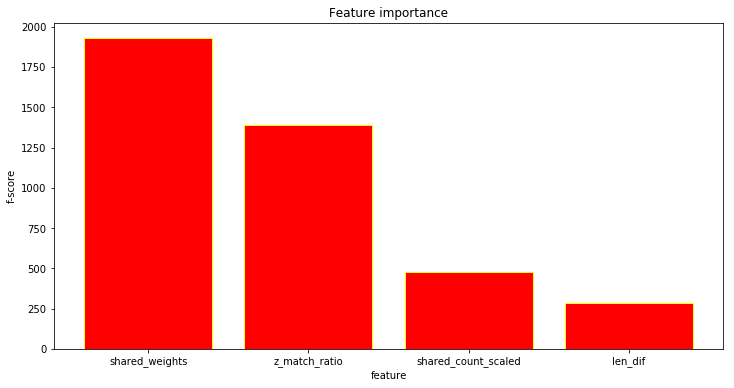

In [77]:
plt.figure(figsize=(12,6))
plt.title('Feature importance')
plt.ylabel('f-score')
plt.xlabel('feature')
plt.bar(range(len(feature_importance.feature)), feature_importance.importance,facecolor='red',edgecolor='yellow', tick_label=feature_importance.feature)
plt.show()

## IV. Results

### Model Evaluation and Validation
Having already decided the model to use, I applied the same transformations to the provided testing data set, in order to get the new features and be able to make predictions.
This provided a different input to test the model, besides the one obtained from the train_test_split method. This new testing set doesn't have the labels in order to test it by my own, but it is possible to test in on the Kaggle platform. This is good, because this data is not used during the training set, so it provides a very robust indicator.

In [63]:
data_test = pd.read_csv("data/test.csv")

In [64]:
questions1_t = data_test.question1.tolist()
questions2_t = data_test.question2.tolist()

questions1_clean_t = cleanQuestions(questions1_t)
questions2_clean_t = cleanQuestions(questions2_t)

questions_t = uniqueQuestions(questions1_clean_t, questions2_clean_t)

100%|██████████| 2345796/2345796 [00:04<00:00, 573572.45it/s]

There are 3345831 unique questions in the dataset.


In [75]:
idf_dict_t = tfIdfVectorizer(questions_t)

In [66]:
unique_tokens_t = [nltk.tokenize.word_tokenize(str(i)) for i in questions_t]

question1_token_t = tokenizeQuestions(questions1_clean_t)
print 'Questions 1 tokenized.'
question2_token_t = tokenizeQuestions(questions2_clean_t)
print 'Questions 2 tokenized.'

Questions 1 tokenized.
Questions 2 tokenized.


In [67]:
shared_words_t, total_words_t = findSharedWords(question1_token_t, question2_token_t)

shared_weights_t, total_weights_t = findSharedWeights(shared_words_t, total_words_t)

weights_t = getWeights(shared_weights_t, total_weights_t)

X_t = pd.DataFrame(weights_t, columns=['shared_weights'])

100%|██████████| 2345796/2345796 [00:59<00:00, 39725.41it/s] 


In [68]:
shared_count_t = [len(x) for x in shared_words_t]

shared_count_cut_t = [x if x < 10 else 10 for x in shared_count_t]

shared_count_scaled_t = MinMaxScaler().fit_transform(np.array(shared_count_cut_t, dtype='float64').reshape(-1, 1))

X_t['shared_count_scaled'] = shared_count_scaled_t.reshape(-1, 1)

del shared_count_t, shared_count_cut_t, shared_count_scaled_t

In [69]:
question1_len_t = [len(x) for x in question1_token_t]
question2_len_t = [len(x) for x in question2_token_t]

len_dif_t = []

for i in range(len(question1_len_t)):
    len_dif_t.append(abs(question1_len_t[i] - question2_len_t[i]))
    
len_dif_cut_t = [5 if i > 5 else i for i in len_dif_t]
len_dif_cut_t = np.array(len_dif_cut_t).reshape(-1, 1)

len_dif_scaled_t = MinMaxScaler().fit_transform(len_dif_cut_t)

X_t['len_dif'] = len_dif_scaled_t

del len_dif_t, len_dif_cut_t

In [70]:
z_match_ratio_t = []

for i in tqdm(range(len(data_test))):
    z_match_ratio_t.append(diff_ratios(data_test.question1[i], data_test.question2[i]))
                         
X_t['z_match_ratio'] = z_match_ratio_t

X_t.head()

100%|██████████| 2345796/2345796 [17:10<00:00, 2277.30it/s]


,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.343711,0.7,1.0,0.384000
1,0.678926,0.8,0.4,0.440367
2,0.732256,0.6,0.6,0.584270
3,0.352562,0.2,0.0,0.545455
4,1.000000,0.4,0.2,0.677419


In [71]:
dtest = xgb.DMatrix(X_t)
y_t = bst.predict(dtest)

In [72]:
y_pred = pd.DataFrame()
y_pred['test_id'] = range(y_t.shape[0])
y_pred['is_duplicate'] = y_t

In [73]:
y_pred.to_csv('sub/final', index=False)

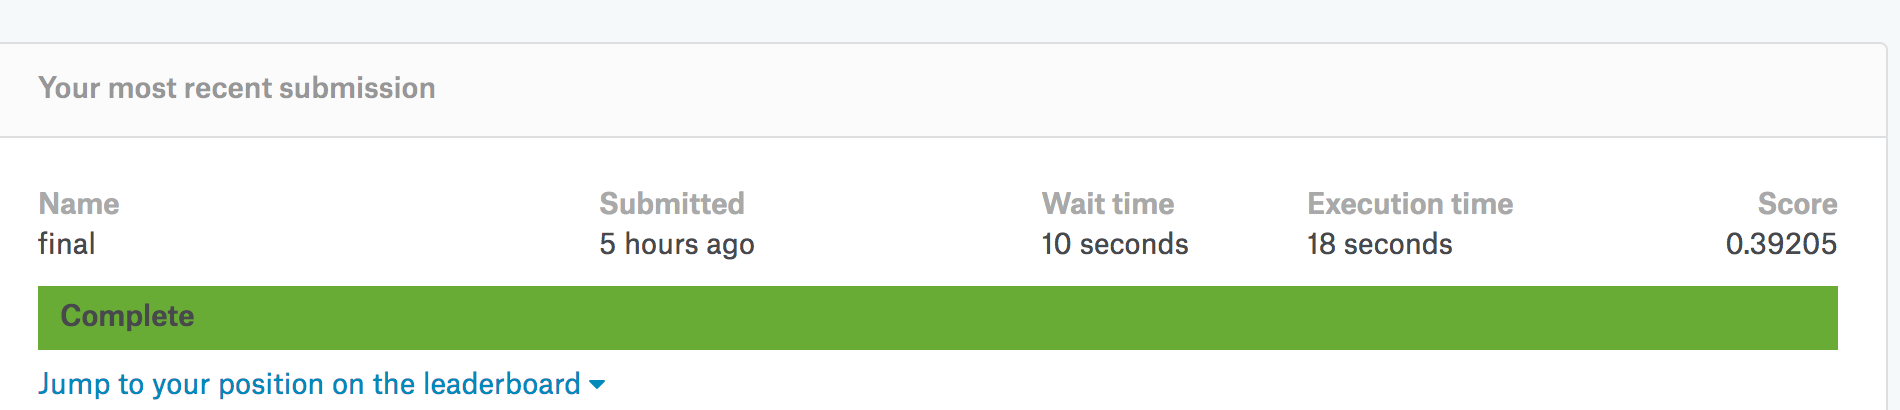

In [74]:
### Kagggle scroe 
from IPython.display import Image
Image("img/kaggle.png")


### Justification

The **final score** obtained in the Kaggle platform is **0.39205**, which is an improvement over the benchmark of **0.55411**. This means that when tested with a totally different input, This value should be improved in order to make significantly good recommendations.

## V. Conclusion

### Reflection

For this project, I started analyzing the basic aspects of the dataset, and getting a naive predictor to use as a benchmark and see if my model would represent an improvement. After this, I preprocessed the training data, and tested that each new feature showed graphically a different distribution between duplicate and non duplicate pair of questions.
Having obtained this, I compared the three models which I believed could be useful for this problem. Given that performances were similar when tested with default parameters, I used GridSearchCV for tunning each of them, and comparing the new results. I chose XGBoost for it's good performance, and it's fast training.
I finally preprocessed the testing data, used my chosen model for prediction, and tested the performance within the Kaggle framework. I got a better result than the benchmark.

I found this problem to be very interesting, given it's high complexity. Natural language processing is involved,  The fact that there are a lot of different ways to ask the same question, some of them very different between each other, makes this problem a very hard one for obtaining a good result. Also, it's not easy to use neural networks in these kind of problems, because each word could be seen as a feature and there are thousands of them.

I think that my model could serve as a first approach for analyzing a problem like this one.

### Improvement

I think there are different ways to improved this algorithm. For example, every word should be contrasted to it's synonyms, in order to group together words that are now consider different but refer to the same. Another improvement could be giving words that start with capital letters a greater weight for TF-IDF analysis.

The problem could also be treated from a different approach, which I would have used if I knew how. As seen in this paper (https://web.stanford.edu/class/cs224n/reports/2759336.pdf), Convolutional Neural Networks can be used for sentence classification. I think that this approach can yield much better results, given the fact that deep learning catches much better aspects where humans are good at, like it does with image recognition.